# Compound clustering

## Aim of this notebook

Compound filtering: Cluster set of compounds in order to extract a diverse set of compounds for downstream tasks, e.g. docking.

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, rdFingerprintGenerator, Draw
from rdkit.ML.Cluster import Butina

RDKit WARNING: [22:07:25] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
DATA_PATH = Path('.') / '..' / '..' / 'data'
MOLECULES_PATH = DATA_PATH / 'focused_library_similar_proteins' / 'focused_library.csv'

## Load molecule library

In [4]:
dataset = pd.read_csv(MOLECULES_PATH)
dataset.shape

(4121, 19)

In [5]:
PandasTools.AddMoleculeColumnToFrame(dataset, smilesCol='canonical_smiles')

## Generate fingerprints

In [6]:
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)

In [7]:
dataset['fingerprint'] = dataset.apply(lambda x: rdkit_gen.GetFingerprint(x.ROMol), axis=1)

## Cluster molecules (Butina algorithm)

Cluster molecules with different distance cutoffs - how many clusters come out?

In [8]:
def cluster_molecules(fingerprints, cutoff=0.6):
    """
    Cluster fingerprints using the Butina algorithm.
    
    Parameters
    ----------
    fingerprints : list of rdkit.DataStructs.cDataStructs.ExplicitBitVect
        List of fingerprints.
    cutoff : float
        Distance cutoff Butina clustering.
        
    Returns
    -------
    list of tuple of int
        List of clusters, whereby each cluster is described by its cluster member IDs.
    """
    
    # Calculate Tanimoto distance matrix
    distance_matrix = _tanimoto_distance_matrix(fingerprints)
    
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(
        distance_matrix,
        len(fingerprints),
        cutoff,
        isDistData=True
    )
    
    # Sort clusters by size
    clusters = sorted(clusters, key=len, reverse=True)
    
    return clusters

def _tanimoto_distance_matrix(fingerprints):
    """
    Calculate distance matrix for list of fingerprints.
    
    Parameters
    ----------
    fingerprints : list of rdkit.DataStructs.cDataStructs.ExplicitBitVect
        List of fingerprints.
        
    Returns
    -------
    list of floats
        Distance matrix (a triangular similarity matrix in the form of a list)
    """
    
    fingerprints = list(fingerprints)
    distance_matrix = []
    
    for i in range(1,len(fingerprints)):
        similarities = DataStructs.BulkTanimotoSimilarity(fingerprints[i], fingerprints[:i])
        
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        distance_matrix.extend([1-x for x in similarities])
    
    return distance_matrix

In [9]:
# Perform clustering with different distance cutoffs

cluster_by_cutoff = {}

for cutoff in np.arange(0, 1, 0.1):
    
    cutoff = round(cutoff, 1)
    
    clusters = cluster_molecules(dataset.fingerprint, cutoff)
    cluster_by_cutoff[cutoff] = clusters

## Get clustering stats (per distance cutoff)

Use these statistics to decide on distance cutoff.

In [10]:
cluster_stats = {
    cutoff: [
        cutoff,  
        sum([len(cluster) > 100 for cluster in clusters]),
        sum([len(cluster) > 25 for cluster in clusters]),
        sum([len(cluster) > 10 for cluster in clusters]),
        sum([len(cluster) > 5 for cluster in clusters]),
        sum([len(cluster) == 1 for cluster in clusters]),
        len(clusters)
    ] for cutoff, clusters in cluster_by_cutoff.items()
}
cluster_stats = pd.DataFrame(
    cluster_stats.values(), 
    columns=['Distance cutoff', '# Clusters > 100', '# Clusters > 25', '# Clusters > 10', '# Clusters > 5', '# Clusters = 1', '# Clusters']
)
cluster_stats

,Distance cutoff,# Clusters > 100,# Clusters > 25,# Clusters > 10,# Clusters > 5,# Clusters = 1,# Clusters
0,0.0,0,0,0,0,3830,3953
1,0.1,0,13,48,135,1164,1782
2,0.2,2,33,93,149,432,862
3,0.3,3,43,90,138,180,460
4,0.4,10,38,81,101,88,269
5,0.5,10,32,62,73,42,165
6,0.6,7,25,44,55,26,109
7,0.7,6,14,23,28,9,42
8,0.8,1,2,2,3,2,8
9,0.9,1,1,1,1,1,2


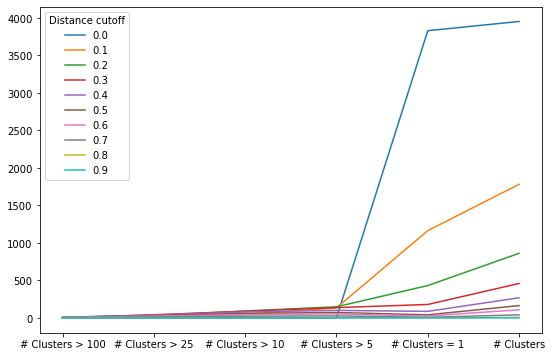

In [11]:
cluster_stats.set_index('Distance cutoff').transpose().plot(figsize=(9,6))

## Draw clusters

This function allows you to draw each cluster of a clustering based on a selected distance cutoff.

In [12]:
def draw_clusters(mols, clusters, max_mols=1000):
    """
    Draw molecules sorted by descending cluster size.
    
    Parameters
    ----------
    mols : list of rdkit.Chem.rdchem.Mol
        Molecules.
    clusters : list of tuple of int
        List of clusters, whereby each cluster is described by its cluster member IDs.
    max_mols : int
        Number of molecules shown per cluster ID (default 1000).
    
    Returns
    -------
    dict of PIL.PngImagePlugin.PngImageFile
        Dictionary of molecules for each cluster (legend = "cluster ID | molecule ID").
    """
    
    img_dict = {}
    
    for cluster_id, cluster in enumerate(clusters):
        
        clustered_mols = []
        legends = []
        
        clustered_mols.extend([mols[mol_id] for mol_id in cluster])
        legends.extend([f'{cluster_id+1} | {mol_id}' for mol_id in cluster])
        
        img = Draw.MolsToGridImage(clustered_mols, legends=legends,  molsPerRow=6, maxMols=max_mols)
        img_dict[cluster_id+1] = img
        
    return img_dict

In [13]:
img_dict = draw_clusters(dataset.ROMol, cluster_by_cutoff[0.6], max_mols=50)

/home/dominique/anaconda2/envs/kffl/lib/python3.6/site-packages/rdkit/Chem/Draw/IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


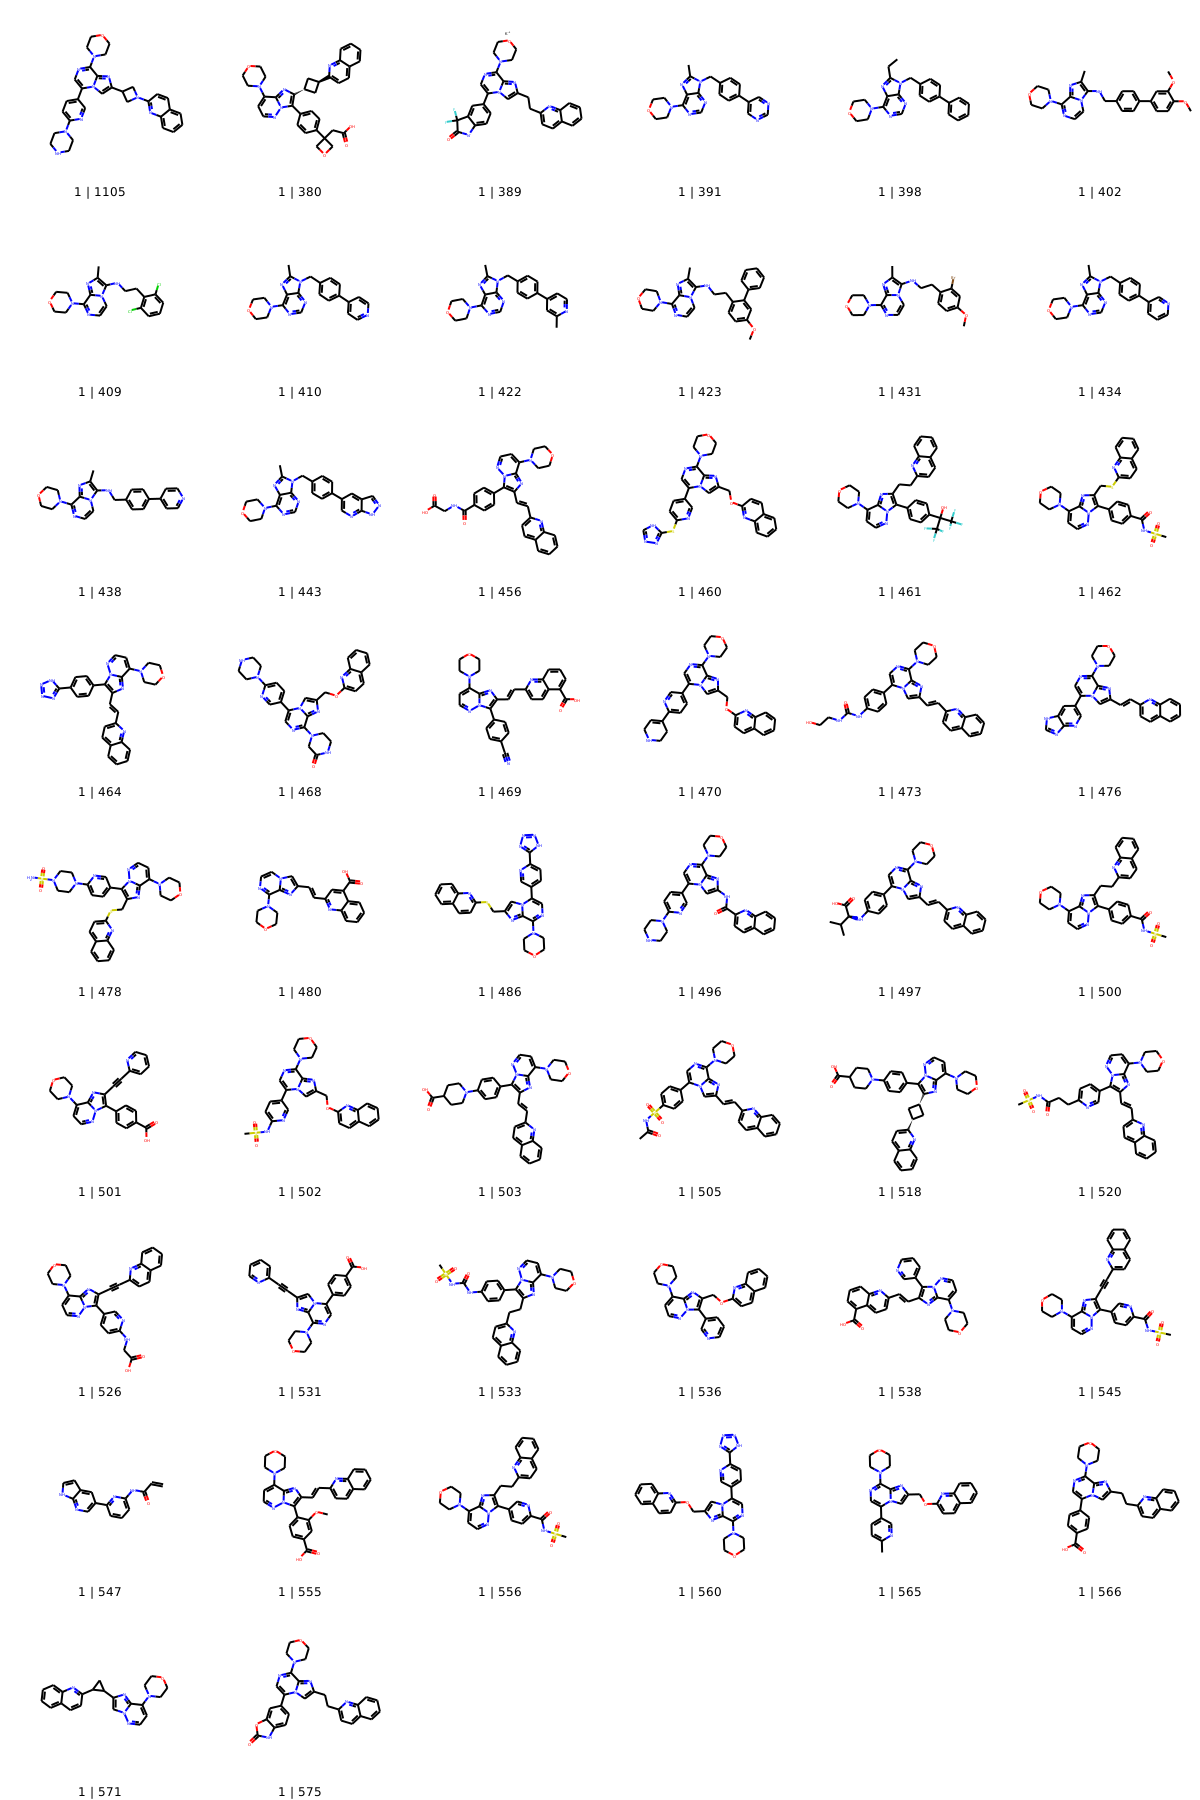

In [14]:
# Show cluster 1 (largest cluster) - by default "only" the first 1000 molecules are shown per cluster
img_dict[1]

## Get cluster centroids

First molecule in each cluster is cluster centroid - thus, extract first molecule per cluster!

In [15]:
cluster_centroids_by_cutoff = {cutoff: [cluster[0] for cluster in clusters] for cutoff, clusters in cluster_by_cutoff.items()} 

In [16]:
def draw_cluster_centroids(mols, cluster_centroids):
    """
    Draw fragments sorted by descending cluster size.
    
    Parameters
    ----------
    mols : list of rdkit.Chem.rdchem.Mol
        List of top x fragments.
    cluster_centroids : list of int
        List of cluster centroids (their molecule IDs).
    
    Returns
    -------
    PIL.PngImagePlugin.PngImageFile
        Image of cluster centroids (legend = "cluster ID | molecule ID").
    """
    
    cluster_centroids_mols = []
    legends = []
    
    for cluster_id, molecule_id in enumerate(cluster_centroids):
        
        cluster_centroids_mols.append(mols[molecule_id])
        legends.append(f'{cluster_id+1} | {molecule_id}')
        
    img = Draw.MolsToGridImage(cluster_centroids_mols, legends=legends,  molsPerRow=6)
    
    return img

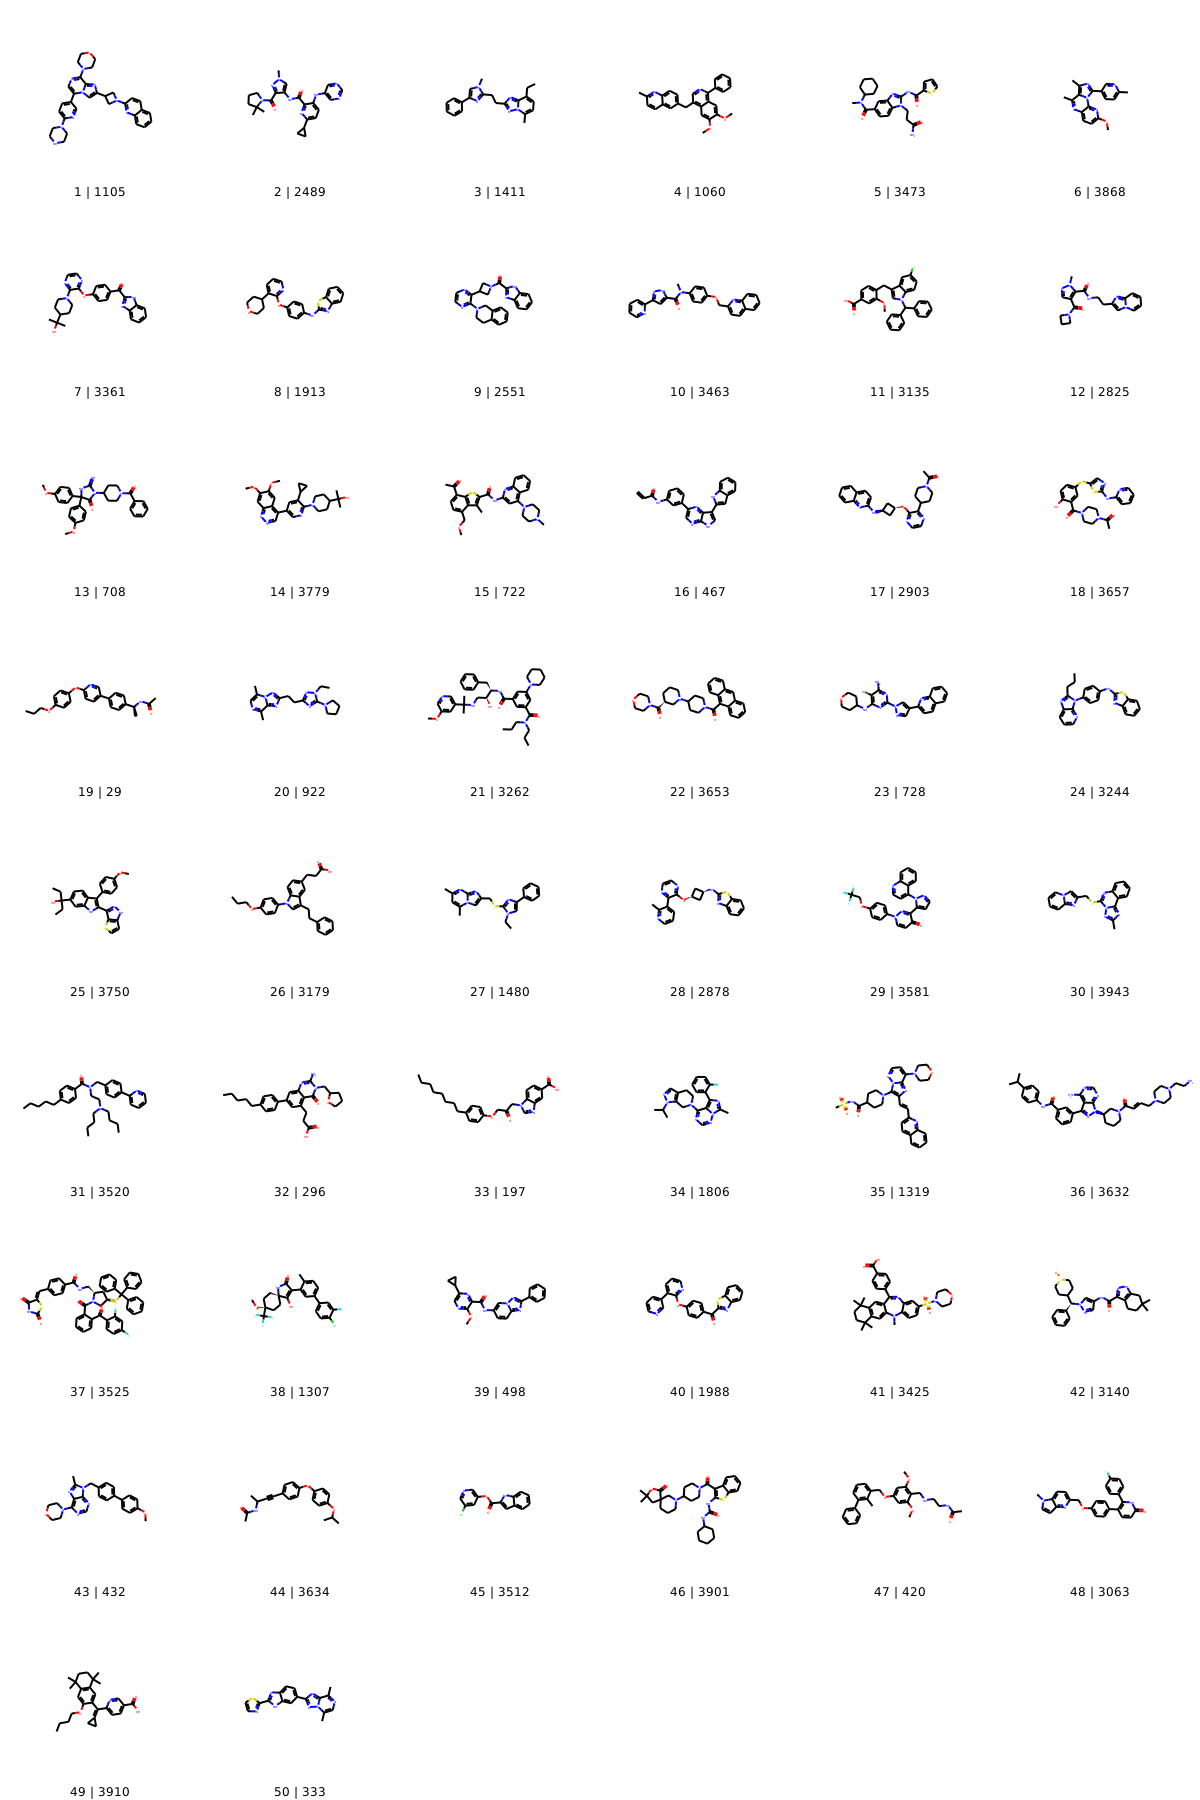

In [17]:
draw_cluster_centroids(dataset.ROMol, cluster_centroids_by_cutoff[0.6])

## Save diverse compounds set to file

In [18]:
dataset.iloc[cluster_centroids_by_cutoff[0.6]].to_csv(MOLECULES_PATH.parent / 'focused_library_diverss.csv')

In [19]:
print(f'Number of moleules in divers set: {len(cluster_centroids_by_cutoff[0.6])}')

Number of moleules in divers set: 109
